In [1]:
import pandas as pd
from IPython.display import SVG
import numpy as np
import os

from sklearn import model_selection
from sklearn import metrics

from keras import layers
from keras import models
from keras.utils import plot_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
from keras import backend as K

Using TensorFlow backend.


In [2]:
df = pd.read_csv('train.csv').sample(50000)


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
392005,392005,524650,524651,Is film actress are too fart loudly?,What is the speed of rain fall all the way?,0
85607,85607,144502,144503,How long does it take for smoking to ruin your...,How much is smoking is injurious to health?,0
40233,40233,72814,72815,I'm presently in second year of engineering.? ...,What are occasions when kissing asses will bac...,0
167697,167697,259936,96722,What is a good solar panel installation provid...,Which is a good solar panel installation provi...,0
251100,251100,233783,65438,What happens if their is suspicious activity o...,How will I know if there is suspicious activit...,1


In [4]:
df['question1'] = df['question1'].fillna('').str.lower().str.replace('[^A-Za-z0-9?!]+', ' ')
df['question2'] = df['question2'].fillna('').str.lower().str.replace('[^A-Za-z0-9?!]+', ' ')

In [5]:
df_train, df_val = model_selection.train_test_split(df)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([df_train['question1'], df_train['question2']]))

word_index = tokenizer.word_index
print('Found {0} unique tokens.'.format(len(word_index)))

Found 29100 unique tokens.


In [7]:
embeddings_index = {}

f = open(os.path.join('/home/eric/data', 'glove.42B.300d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    if word in word_index:
        embeddings_index[word] = coefs

f.close()

print('Found {0} word vectors.'.format(len(embeddings_index)))

Found 27665 word vectors.


In [9]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Siamese MaLSTM

Inspired from [How to predict Quora Question Pairs using Siamese Manhattan LSTM](https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07)

/home/eric/code/venvs/data3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/eric/code/venvs/data3/lib/python3.5/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


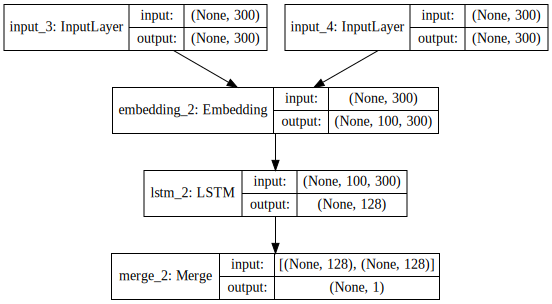

In [12]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

shared_embedding = layers.Embedding(input_dim=len(word_index) + 1,
                                    output_dim=300,
                                    weights=[embedding_matrix],
                                    input_length=100,
                                    trainable=False)

shared_lstm = layers.LSTM(128)

x1a = layers.Input(shape=(300,), dtype='int32')
h1a = shared_embedding(x1a)
h1a = shared_lstm(h1a)

x1b = layers.Input(shape=(300,), dtype='int32')
h1b = shared_embedding(x1b)
h1b = shared_lstm(h1b)

malstm_distance = layers.merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                               output_shape=lambda x: (x[0][0], 1),
                               inputs=[h1a, h1b])

model = models.Model(inputs=[x1a, x1b],
                     outputs=[malstm_distance])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
x_train1 = pad_sequences(tokenizer.texts_to_sequences(df_train['question1']), 300)
x_train2 = pad_sequences(tokenizer.texts_to_sequences(df_train['question2']), 300)

x_val1 = pad_sequences(tokenizer.texts_to_sequences(df_val['question1']), 300)
x_val2 = pad_sequences(tokenizer.texts_to_sequences(df_val['question2']), 300)

In [14]:
model.fit(x=[x_train1, x_train2],
          y=df_train['is_duplicate'].values,
          validation_data=([x_val1, x_val2], df_val['is_duplicate'].values),
          epochs=3)

Train on 37500 samples, validate on 12500 samples
Epoch 1/3
37500/37500 [==============================] - 2510s 67ms/step - loss: 0.1918 - acc: 0.7194 - val_loss: 0.1799 - val_acc: 0.7262
Epoch 2/3
37500/37500 [==============================] - 1667s 44ms/step - loss: 0.1571 - acc: 0.7604 - val_loss: 0.1723 - val_acc: 0.7390
Epoch 3/3
37500/37500 [==============================] - 1514s 40ms/step - loss: 0.1454 - acc: 0.7839 - val_loss: 0.1660 - val_acc: 0.7533


In [15]:
metrics.roc_auc_score(list(map(lambda r: 1 if r > 0.5 else 0, model.predict([x_val1, x_val2]))),
                      df_val['is_duplicate'].values)

0.7396766683312893